# Пример использования библиотеки BigARTM для тематического моделирования
## Для Bigartm v0.8.0
### Редактировал Максим Чурилин

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [3]:
batch_vectorizer = artm.BatchVectorizer(data_path="../data/school.txt", data_format="vowpal_wabbit", target_folder="../data/school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="../data/school_batches", data_format='batches')

Создаем объект модели:

In [5]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

Создаем словарь и инициализируем модель с его помощью

In [6]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [7]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                           dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

In [8]:
model_artm.initialize('dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [9]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

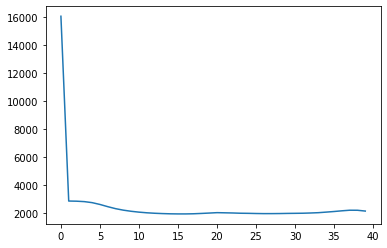

In [10]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [11]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end=" ")
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print(word, end=" ")
    print

sbj0:  который быть что это человек этот как свой для они его весь такой время себя sbj1:  a множитель возведение b скобка x раскладывать умножение сокращенный разложение ответ квадрат слагаемое многочлен выражение sbj2:  обособление куприн слово раскольников мастер роман словосочетание маргарита подчинительный соня оборот вера браслет старик сантьяго sbj3:  который быть год свой время государство человек мир становиться жизнь северный первый война африка ребенок sbj4:  x a b уравнение дробь квадратный y степень функция число f решение корень c пример sbj5:  быть год пушкин функция свой его русский который поэт империя культура весь a f трение sbj6:  сила быть тело энергия поле при магнитный точка географический наречие если частица например заряд величина sbj7:  который что это как человек для этот такой быть являться мочь себя она его свой sbj8:  который быть что это свой как этот человек для x они такой государство a весь sbj9:  который быть что этот это как человек свой для такой в

Давайте посмотрим также на разреженность матриц:

In [12]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.7333188652992249
0.16533613204956055


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [13]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [14]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [15]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.8168085217475891
0.3025210201740265


Попробуем менять коэффициент регуляризации:

In [16]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [17]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [18]:
# еще раз посмотрим на разреженность
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.9105099439620972
0.4848739504814148


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [19]:
model_artm.save("../data/my_model")

In [20]:
model_artm.load("../data/my_model")

Можно попросить матрицы в чистом виде:

In [21]:
phi = model_artm.get_phi()

In [22]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
пластинка,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000011
фотопластинка,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000023
Добросклонова,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000011
лирикиОсобенно,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000011
вправе,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000011
...,...,...,...,...,...,...,...,...,...,...
кинетический,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000275
спроецировать,0.00007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
соотноситься,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000011
эпицентр,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000011


Матрица вероятностей тем в документах.

In [23]:
theta = model_artm.get_theta()
theta

,100,101,102,103,104,105,106,107,108,109,...,390,391,392,393,394,395,396,397,398,399
sbj0,0.045603,0.070671,0.034384,0.085837,0.165493,0.047847,0.151235,0.096491,0.053872,0.020243,...,0.301038,0.217631,0.335009,0.438202,0.448997,0.545729,0.381868,0.198473,0.234286,0.477607
sbj1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj3,0.058562,0.307421,0.014327,0.347639,0.080986,0.014354,0.086420,0.004386,0.003367,0.097166,...,0.006920,0.024793,0.037288,0.011236,0.024465,0.013863,0.030220,0.041985,0.000000,0.099707
sbj4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj5,0.010053,0.113074,0.005731,0.012876,0.031690,0.054372,0.033951,0.074561,0.037037,0.008097,...,0.027682,0.008264,0.017534,0.028090,0.015291,0.072761,0.005495,0.057252,0.051429,0.049853
sbj6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj7,0.096993,0.003534,0.299236,0.017167,0.024648,0.243195,0.030838,0.096459,0.006734,0.068826,...,0.003460,0.011019,0.027119,0.028090,0.015291,0.011765,0.000000,0.015267,0.011429,0.011730
sbj8,0.042861,0.127209,0.054807,0.103004,0.116197,0.062765,0.071014,0.109681,0.191919,0.064777,...,0.076125,0.088154,0.115254,0.050562,0.055591,0.032353,0.101648,0.091603,0.222857,0.070781
sbj9,0.745928,0.378092,0.591516,0.433477,0.580986,0.577467,0.626543,0.618421,0.707070,0.740890,...,0.584775,0.650138,0.467796,0.443820,0.440367,0.323529,0.480769,0.595420,0.480000,0.290322


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [24]:
theta_test = model_artm.transform(batch_vectorizer)